In [1]:
import os
from typing import List

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [8]:
def cagr(data: pd.DataFrame, date_col: str, groups: List[str], metric: str, n_periods: float):
    """Calculate compound annual growth ratio for a given metric."""
    df = data.copy()
    growth = df.groupby(groups + [date_col]).sum()
    growth = growth.reset_index()
    compound = growth.groupby(groups)[value].last() / growth.groupby(groups)[value].first()
    compound = 100 * (compound ** (1 / n_periods) - 1)
    compound = compound.reset_index()
    return compound


def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.2f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

In [2]:
empresas = pd.read_csv('../data/01_raw/operadora_empresa.csv')
empresas = empresas.rename(columns=str.lower)

In [3]:
benef_uf_path = '../data/01_raw/beneficiarios_uf'
benef_uf_files = [(os.path.join(benef_uf_path, f.name), f.name.replace('.csv', ''))  # (path, reference date)
                  for f in os.scandir(benef_uf_path) if not f.is_dir()]

benef_uf = pd.DataFrame()
for fp, ref_date in benef_uf_files:
    df = pd.read_csv(fp, encoding='utf-8-sig', sep=',')
    df['data_ref'] = ref_date
    benef_uf = pd.concat([benef_uf, df])

In [4]:
benef_uf = benef_uf.rename(columns=str.lower)
benef_uf['cod_operadora'] = benef_uf['operadora'].apply(lambda val: val.split('-')[0])
benef_uf['cod_operadora'] = benef_uf['cod_operadora'].astype(int)

In [5]:
estados = {
    'acre': 'AC',
    'alagoas': 'AL',
    'amapá': 'AP',
    'amazonas': 'AM',
    'bahia': 'BA',
    'ceará': 'CE',
    'distrito federal': 'DF',
    'espírito santo': 'ES',
    'goiás': 'GO',
    'maranhão': 'MA',
    'mato grosso': 'MT',
    'mato grosso do sul': 'MS',
    'minas gerais': 'MG',
    'pará': 'PA',
    'paraíba': 'PB',
    'paraná': 'PR',
    'pernambuco': 'PE',
    'piauí': 'PI',
    'rio de janeiro': 'RJ',
    'rio grande do norte': 'RN',
    'rio grande do sul': 'RS',
    'rondônia': 'RO',
    'roraima': 'RR',
    'santa catarina': 'SC',
    'são paulo': 'SP',
    'sergipe': 'SE',
    'tocantins': 'TO',
}
benef_uf = benef_uf.rename(columns=estados)

## Histórico de número de beneficiários por empresa

In [6]:
historico = empresas.merge(benef_uf, on='cod_operadora', how='inner')
historico = historico.drop('operadora', axis=1)
historico = historico.melt(id_vars=['cod_operadora', 'nome_empresa', 'data_ref'],
                           var_name='uf', value_name='beneficiarios')

historico_empresa = historico.groupby(['nome_empresa', 'data_ref', 'uf'])['beneficiarios'].sum()
historico_empresa = historico_empresa.reset_index()
historico_empresa = historico_empresa.sort_values(['nome_empresa', 'uf', 'data_ref'])

regioes = {
    'AC': 'N',
    'AL': 'NE',
    'AM': 'N',
    'AP': 'N',
    'BA': 'NE',
    'CE': 'NE',
    'DF': 'CO',
    'ES': 'SE',
    'GO': 'CO',
    'MA': 'NE',
    'MG': 'SE',
    'MS': 'CO',
    'MT': 'CO',
    'PA': 'N',
    'PB': 'NE',
    'PI': 'NE',
    'PR': 'S',
    'RJ': 'SE',
    'RN': 'NE',
    'RO': 'N',
    'RR': 'N',
    'RS': 'S',
    'SC': 'S',
    'SE': 'NE',
    'SP': 'SE',
    'TO': 'N',
}
historico_empresa['regiao'] = historico_empresa['uf'].map(regioes)

In [7]:
historico_empresa.head()

nome_empresa data_ref  uf  beneficiarios regiao
0           Amil   201203  AC            194      N
27          Amil   201303  AC            139      N
54          Amil   201403  AC            117      N
81          Amil   201503  AC            115      N
108         Amil   201603  AC            144      N

### CAGR do Número de Beneficiários por Região

In [10]:
n_years = historico_empresa['data_ref'].nunique()
cagr_regiao = cagr(historico_empresa, 'data_ref', ['regiao'], 'beneficiarios', n_years)
cagr_regiao

regiao  beneficiarios
0     CO       4.929569
1      N       0.748932
2     NE       3.903264
3      S       1.819237
4     SE       1.814204

### CAGR do Número de Beneficiários de cada Empresa por Região

In [11]:
cagr_empresa_regiao = cagr(historico_empresa, 'data_ref', ['regiao', 'nome_empresa'], 'beneficiarios', n_years)

### Evolução da Participação de cada Empresa por Região

In [23]:
# Participação por Estado
total_uf = historico_empresa.groupby(['uf', 'data_ref']).sum()
participacao_empresa = historico_empresa.merge(total_uf, how='inner', on=['uf', 'data_ref'], suffixes=['', '_uf'])
participacao_empresa['participacao_uf'] = participacao_empresa['beneficiarios'] / participacao_empresa['beneficiarios_uf']

# Participação por Região
total_regiao = historico_empresa.groupby(['regiao', 'data_ref']).sum()
operadora_regiao = historico_empresa.groupby(['nome_empresa', 'regiao', 'data_ref']).sum()
operadora_regiao = operadora_regiao.reset_index()

operadora_regiao = operadora_regiao.merge(total_regiao, how='inner', on=['regiao', 'data_ref'], suffixes=['', '_regiao'])
operadora_regiao['participacao_regiao'] = 100 * operadora_regiao['beneficiarios'] / operadora_regiao['beneficiarios_regiao']

# CAGR da participação
cagr_participacao_empresa = cagr(operadora_regiao, 'data_ref', ['regiao', 'nome_empresa'], 'participacao_regiao', n_years)

In [24]:
part_final = operadora_regiao.query('data_ref == "202003"')[['nome_empresa', 'regiao', 'participacao_regiao']]
part_final = part_final.rename(columns={'participacao_regiao': 'participacao_2020'})

part_inicial = operadora_regiao.query('data_ref == "201203"')[['nome_empresa', 'regiao', 'participacao_regiao']]
part_inicial = part_inicial.rename(columns={'participacao_regiao': 'participacao_2012'})

In [25]:
crescimento = cagr_empresa_regiao.merge(cagr_participacao_empresa, on=['regiao', 'nome_empresa'], how='inner')
crescimento = crescimento.merge(part_inicial, on=['regiao', 'nome_empresa'], how='inner')
crescimento = crescimento.merge(part_final, on=['regiao', 'nome_empresa'], how='inner')
crescimento = crescimento.sort_values(['regiao', 'participacao_2020'], ascending=False)
crescimento

regiao      nome_empresa  beneficiarios  participacao_regiao  \
49     SE           Unimeds       1.024205            -0.775922   
40     SE              Amil       1.187464            -0.615572   
42     SE          Bradesco       1.486114            -0.322243   
47     SE        Sulamerica       1.760475            -0.052772   
45     SE           HAPVIDA       8.690324             6.753597   
41     SE             Assim       7.825542             5.904223   
46     SE           Prevent      13.553183            11.529805   
48     SE  Sulamerica - ASO       8.701685             6.764755   
44     SE              GNDI       1.744495            -0.068467   
43     SE    Bradesco - ASO      -3.642058            -5.359037   
39      S           Unimeds       1.585365            -0.229694   
34      S              GNDI      14.734404            12.684408   
32      S          Bradesco      -2.492406            -4.234605   
30      S              Amil      -0.833220            -2.605065   
37      S        Sulamerica      -0.046001            -1.831911   
35      S           HAPVIDA      38.117491            35.649702   
38      S  Sulamerica - ASO      -4.645923            -6.349645   
33      S    Bradesco - ASO     -14.421247           -15.950310   
36      S           Prevent       4.944773             3.069691   
31      S             Assim      25.992105            23.740964   
29     NE           Unimeds       2.700508            -1.157573   
25     NE           HAPVIDA       8.036991             3.978438   
22     NE          Bradesco       0.956026            -2.836521   
20     NE              Amil      -1.089692            -4.805389   
27     NE        Sulamerica       2.204900            -1.634563   
23     NE    Bradesco - ASO      -4.973515            -8.543312   
28     NE  Sulamerica - ASO      23.205720            18.577334   
26     NE           Prevent      -3.633933            -7.254052   
24     NE              GNDI      -5.005497            -8.574092   
21     NE             Assim       9.055232             4.958427   
19      N           Unimeds      -2.005026            -2.733486   
15      N           HAPVIDA       9.414454             8.601106   
12      N          Bradesco      -1.820536            -2.550368   
17      N        Sulamerica      -8.322346            -9.003845   
10      N              Amil       5.174054             4.392227   
18      N  Sulamerica - ASO      15.200429            14.344069   
13      N    Bradesco - ASO       4.151288             3.377064   
14      N              GNDI      29.154967            28.194874   
16      N           Prevent      13.496727            12.653032   
11      N             Assim      12.983096            12.143220   
9      CO           Unimeds       3.752365            -1.121899   
5      CO           HAPVIDA      19.165234            13.566877   
2      CO          Bradesco       4.633965            -0.281717   
0      CO              Amil      -0.460217            -5.136575   
7      CO        Sulamerica       6.677858             1.666155   
8      CO  Sulamerica - ASO      16.307175            10.843089   
3      CO    Bradesco - ASO       0.025465            -4.673710   
6      CO           Prevent      11.476292             6.239160   
4      CO              GNDI      16.051494            10.599419   
1      CO             Assim      -9.679893           -13.923112   

    participacao_2012  participacao_2020  
49          55.521212          51.762184  
40          14.543562          13.757384  
42          13.537593          13.150001  
47           8.148146           8.109529  
45           2.326966           4.190180  
41           1.593266           2.669978  
46           0.990175           2.643812  
48           1.093106           1.970214  
44           0.984143           0.978095  
43           1.261830           0.768623  
39          83.646025          81.932661  
34           2.524254           7.394476  
32           6.049562     

## Visualização: Evolução da Participação de cada Empresa

Aqui observamos a variação da participação e o crescimento anualizado de cada prestadora de serviço, por região.

O interessante de analisar a evolução de participação é a relativa independencia em relação a ciclos economicos. 
Se assumirmos que não haverá crescimento nos próximos anos, algumas empresas ainda podem se beneficiar de uma tomada de share ou da manutenção de uma porção significativa de mercado.

### Destaques Nacionais
1. __Perda de share das Unimeds__:
    - Mantém-se como maior incumbente em todas as regiões.
    - Aparecem com perda de share em todas as regiões, apesar de apresentar crescimento absoluto de seu número de beneficiários.
    - Perda é mais acentuada nas regiões Norte, Centroeste e Nordeste, nas quais a HAPVIDA tem mostrado crescimento significativo.
2. __Surgimento de segundo player dominante com proposta de atendimento verticalizado (HAPVIDA e GNDI)__: 
    - Nas regiões Nordeste, Norte e Centroeste, a HAPVIDA cresce significativamente, se tornando o 2° maior player em participação do mercado regional. 
    - Na região Sul, GNDI se aproxima de 10% do total de beneficiários da região.
    - HAPVIDA e GNDI são players que apresentam propostas de atendimento verticalizado.
    - Em um mercado que favorece a concentração e que tem se concentrado fortemente nas últimas décadas, empresas de rápido crescimento e que adquiram porção significativa do mercado passam a se beneficiar de fatores de escala relevantes como atração a clientes, negociação e credenciamento de prestadores de serviço para sua rede.

### Destaques por Empresa
1. __HAPVIDA__
    - Crescimento acelerado em todas as regiões, com resultados mais expressivos de aumento de participação em CO, N, NE
    - Interessantemente, os momentos das 3 regiões parecem ser fases seguidas da expansão:
        - Centroeste: Crescimento e aumento de share acelerado, aparecimento como segundo maior player e atingimento de cerca de 15% de share
        - Norte: Consolidação como grande participante do mercado, predação ampla de clientes dos incumbentes (Unimeds)
        - Nordeste: Aproximação do percentual de participação no mercado tido pelas Unimeds. Desaceleração do crescimento de share e movimento de estabilização.
    - Esse "faseamento" indica que a empresa já conseguiu obter relevancia em dois mercados e pode adquirir boa parte do share do incumbente no Centroeste caso consiga repetir o processo em outra região
    - As regiões Norte e Nordeste são também as regiões em que há menor penetração de planos de saúde, o que suscita alguns pontos relevantes:
        - Possibilidade de expansão dos níveis de contratação da população dessas regiões em movimentos de catch-up de renda e de expansão dos gastos em saúde para níveis compatíveis com os vistos nas outras regiões do país.
            - População das regiões é ~4x a da região Centroeste.
            - Aumento em 5% da penetração de planos de saúde na região NE adicionaria ~2.2M novos contratos.
        - Mesmo com share considerável nessas regiões, número total de beneficiários não é ainda tão grande. Esse patamar pode mudar com a expansão na região Sudeste, na qual a empresa tem apenas 4.2% de participação.
2. __GNDI__
    - Momento na região Sul parece similar ao que vemos na região Centroeste para a HAPVIDA.
    - Uma vantagem de se consolidar como player de relevancia na região Sul é o atendimento de uma população de maior idade média e maior penetração de serviços de saúde.
    - Isso pode levar a um número elevado de beneficiários, ainda que geograficamente concentrado.
    - Região Sul é a que apresenta maior grau de concentração entre as OPS. Tendencia nacional indica que deve haver possibilidades de predação de share das Unimeds, como no restante do país.
    - Na região Sudeste, apresenta crescimento comparável com o observado para 
3. __Sulamerica__
    - Empresa apresenta participação relativamente constante nos seus principais mercados (SE).
    - Crescimento acelerado no número de beneficiários e na participação para serviços de administração de planos (ASO).
    - Crescimento sustentado do número de beneficiários nos planos próprios (1.76% a.a.)
    - Foco no business de saúde indica que empresa dedicará mais recursos e esforços na expansão das linhas de serviço acima, provavelmente em especial na região sudeste, onde apresenta maior predominancia.
4. __Unimeds__
    - Apresentam perda de market share em todos os mercados, com maior estabilidade na região Sul
    - Quantidade absoluta de beneficiários cresceu em todas as regiões, exceto Norte, a taxas >= 1% ao ano.

In [26]:
plt.style.use('fivethirtyeight')

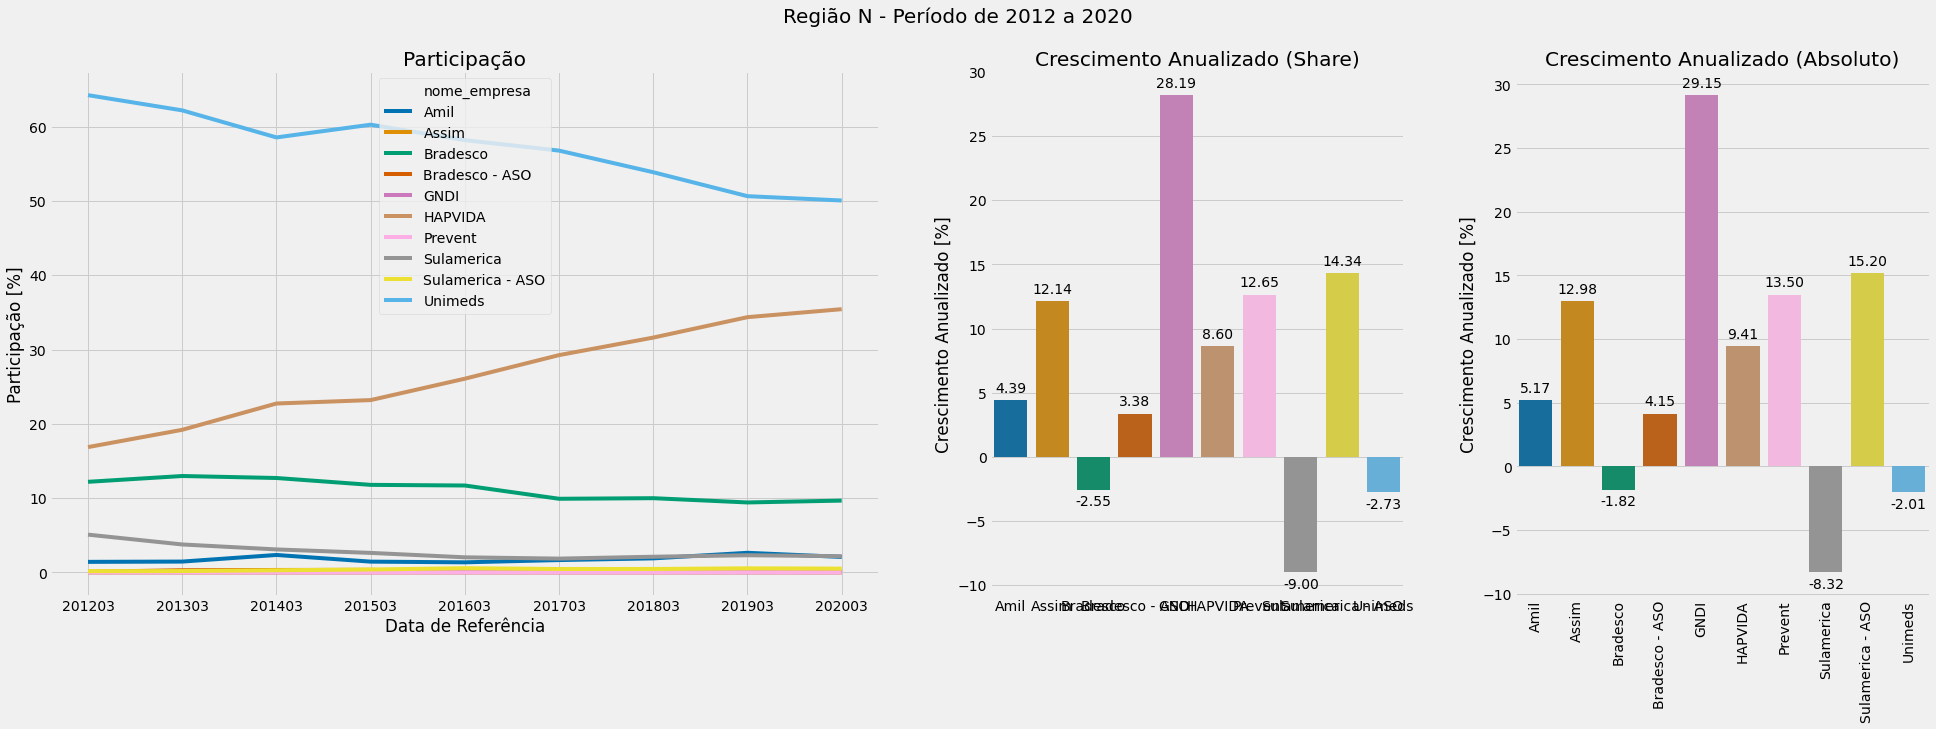

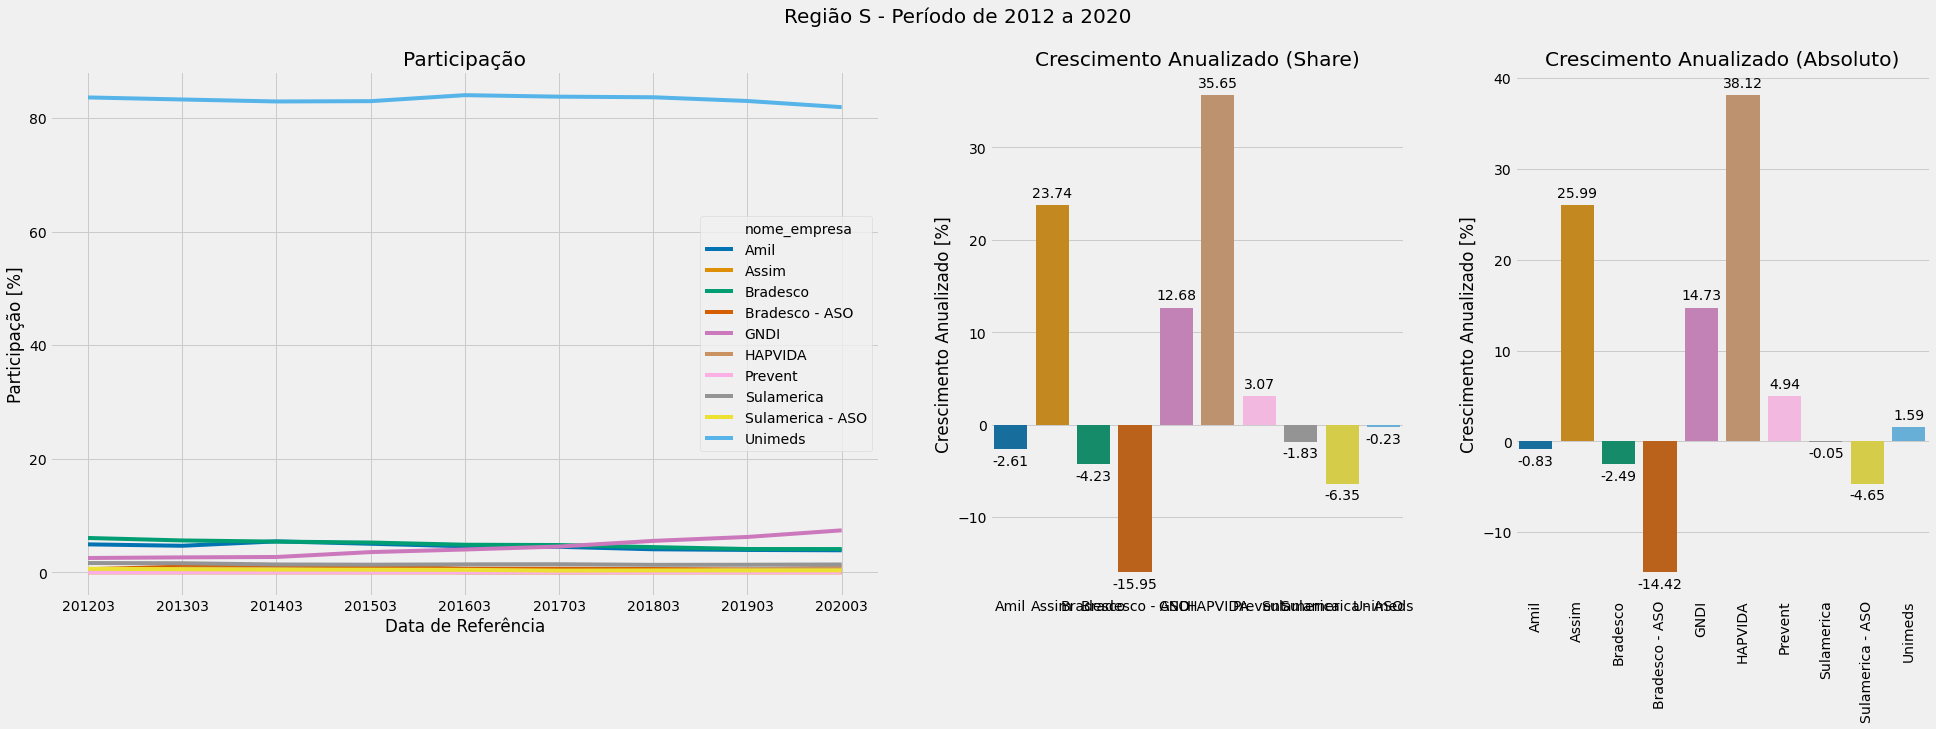

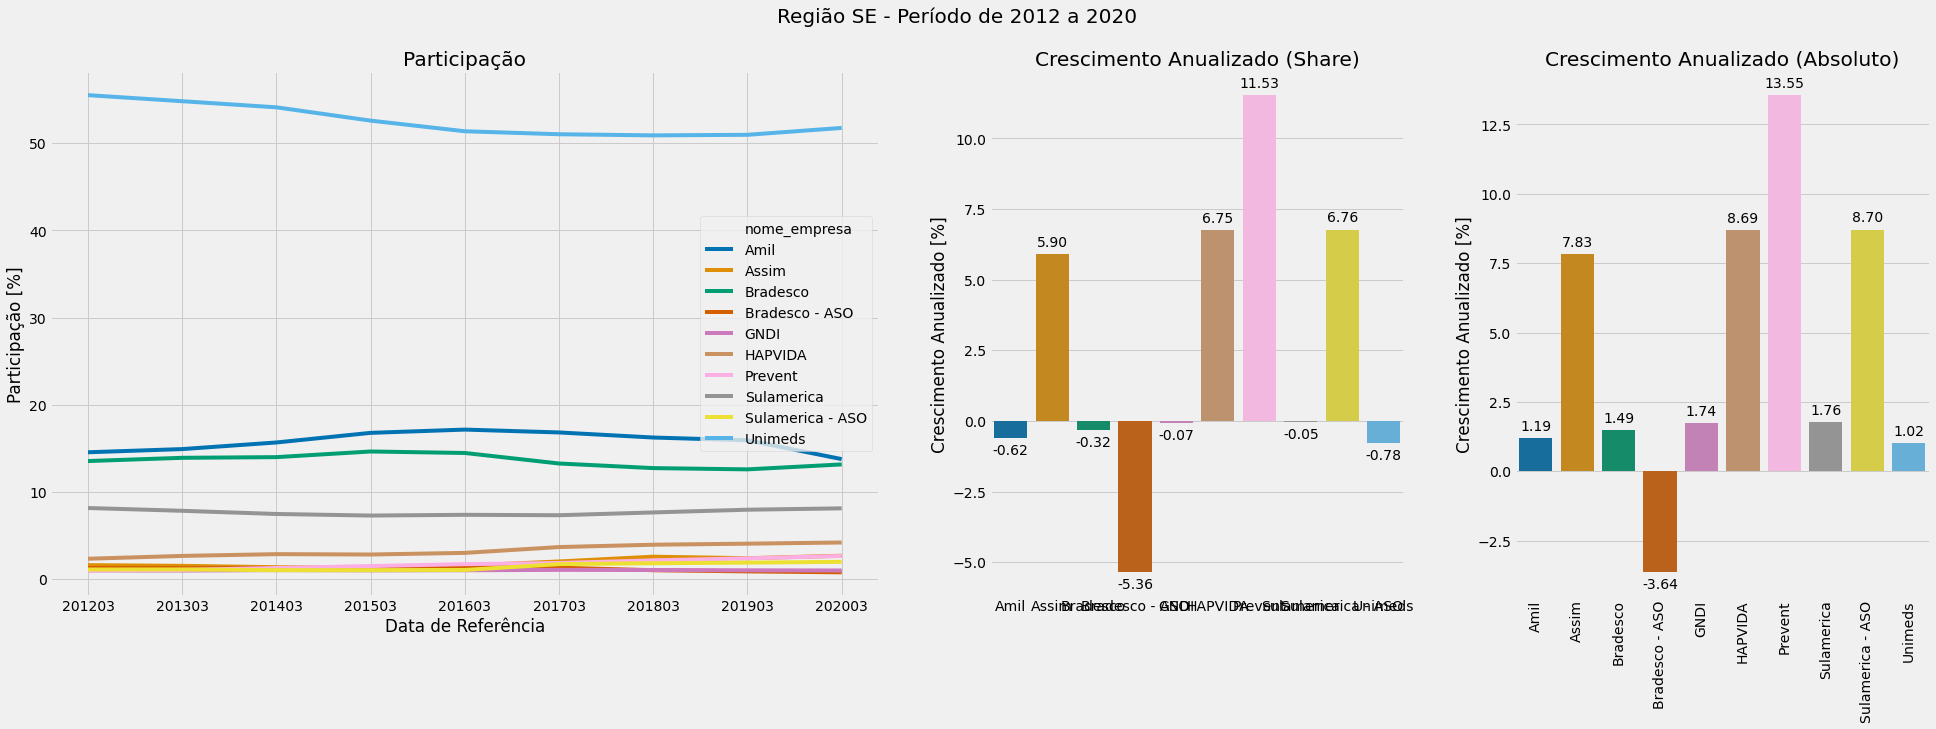

In [51]:
order = operadora_regiao['nome_empresa'].unique()

for region in operadora_regiao['regiao'].unique():
    _part = operadora_regiao[operadora_regiao['regiao'] == region]
    _cagr = crescimento[crescimento['regiao'] == region]
    
    fig, axs = plt.subplots(1, 3, figsize=(30, 9), gridspec_kw={'width_ratios': [2, 1, 1]})
    fig.suptitle(f'Região {region} - Período de 2012 a 2020', fontsize=20)
    
    sns.lineplot(data=_part, x='data_ref', y='participacao_regiao', hue='nome_empresa', ax=axs[0], palette='colorblind', hue_order=order)
    axs[0].set_title('Participação')
    axs[0].set_xlabel('Data de Referência')
    axs[0].set_ylabel('Participação [%]')
    
    sns.barplot(data=_cagr, x='nome_empresa', y='participacao_regiao', ax=axs[1], palette='colorblind', order=order)
    axs[1].set_title('Crescimento Anualizado (Share)')
    axs[1].set_xlabel('')
    axs[1].set_ylabel('Crescimento Anualizado [%]')
    plt.xticks(rotation=90)    
    add_value_labels(axs[1])
    
    sns.barplot(data=_cagr, x='nome_empresa', y='beneficiarios', ax=axs[2], palette='colorblind', order=order)
    axs[2].set_title('Crescimento Anualizado (Absoluto)')
    axs[2].set_xlabel('')
    axs[2].set_ylabel('Crescimento Anualizado [%]')
    plt.xticks(rotation=90)
    add_value_labels(axs[2])
